In [ ]:
!pip install rasterio
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 21.3 MB/s eta 0:00:00


In [ ]:
import os
import re
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from google.colab import drive
from tqdm import tqdm  # 用于显示进度条

# 1. 挂载 Google Drive
drive.mount('/content/drive')

# 2. 设置路径
data_dir = "/content/drive/MyDrive/data"
shapefile_path = "/content/drive/MyDrive/shp/gadm41_MAR_0.shp"
output_dir = "/content/drive/MyDrive/data/morocco_clipped"  # 结果保存路径

# 3. 确保输出文件夹存在
os.makedirs(output_dir, exist_ok=True)

# 4. 读取 Shapefile 并检查 CRS
gdf = gpd.read_file(shapefile_path)

# 获取文件夹中的所有 TIF 文件
all_files = [f for f in os.listdir(data_dir) if f.endswith(".tif")]

# 用正则筛选符合 200003 至 202012 的文件
pattern = re.compile(r"SM\.1km\.Month\.(\d{6})\.Global\.v001\.tif")

filtered_files = []
for file in all_files:
    match = pattern.search(file)
    if match:
        date = int(match.group(1))
        if 200003 <= date <= 202012:
            filtered_files.append(file)

# 5. 遍历符合条件的 TIF 文件并裁剪
for file in tqdm(filtered_files, desc="Processing TIF files"):
    input_path = os.path.join(data_dir, file)
    output_path = os.path.join(output_dir, file.replace(".tif", "_morocco.tif"))

    # 读取栅格并进行裁剪
    with rasterio.open(input_path) as src:
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)  # 确保投影匹配

        geoms = [feature["geometry"] for feature in gdf.to_dict("records")]

        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()

        # 更新元数据
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # 保存裁剪后的 TIF
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

print(f"✅ 处理完成！裁剪后的文件保存在: {output_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing TIF files: 100%|██████████| 250/250 [07:08<00:00,  1.71s/it]

✅ 处理完成！裁剪后的文件保存在: /content/drive/MyDrive/data/morocco_clipped


In [ ]:
import os
import re
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from tqdm import tqdm
from google.colab import drive


# 2. 设置路径
data_dir = "/content/drive/MyDrive/data"
shapefile_path = "/content/drive/MyDrive/shp/gadm41_MAR_0.shp"
output_dir = "/content/drive/MyDrive/data/morocco_clipped2"
os.makedirs(output_dir, exist_ok=True)

# 3. 读取 Shapefile 并检查 CRS
gdf = gpd.read_file(shapefile_path)

# 处理 MultiPolygon，选择最大面积的 Polygon
if gdf.geometry.iloc[0].geom_type == "MultiPolygon":
    gdf["area"] = gdf.geometry.area
    gdf = gdf.sort_values("area", ascending=False).iloc[:1]
    gdf = gdf.drop(columns=["area"])

# 4. 获取符合 200003-202012 规则的 TIF 文件
all_files = [f for f in os.listdir(data_dir) if f.endswith(".tif")]
pattern = re.compile(r"SM\.1km\.Month\.(\d{6})\.Global\.v001\.tif")
filtered_files = [f for f in all_files if pattern.search(f) and 200003 <= int(pattern.search(f).group(1)) <= 202012]

# 5. 遍历 TIF 文件进行裁剪
for file in tqdm(filtered_files, desc="Processing TIF files"):
    input_path = os.path.join(data_dir, file)
    output_path = os.path.join(output_dir, file.replace(".tif", "_morocco.tif"))

    with rasterio.open(input_path) as src:
        # 确保 Shapefile 和 TIF 的 CRS 一致
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # 获取 Shapefile 的几何信息
        geoms = [feature["geometry"] for feature in gdf.to_dict("records")]

        # 进行掩膜裁剪
        out_image, out_transform = mask(src, geoms, crop=True)

        # 保持 -1 作为 NoData
        out_image = np.where(out_image == src.nodata, -1, out_image)

        # 更新元数据
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": -1  # 继续使用 -1 作为 NoData
        })

        # 保存裁剪后的文件
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

print(f"✅ 处理完成！裁剪后的文件保存在: {output_dir}")


<ipython-input-1-9f989f4b3f8b>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["area"] = gdf.geometry.area
Processing TIF files: 100%|██████████| 250/250 [03:44<00:00,  1.11it/s]

✅ 处理完成！裁剪后的文件保存在: /content/drive/MyDrive/data/morocco_clipped2


In [ ]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from tqdm import tqdm  # 进度条工具

# 配置路径
input_dir = "/content/drive/MyDrive/data"
shp_path = "/content/drive/MyDrive/shp/gadm41_MAR_0.shp"
output_dir = "/content/drive/MyDrive/data/clipped_results"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 加载边界数据
print("正在加载Shapefile...")
maroc = gpd.read_file(shp_path)

def process_tiff(input_path, output_path):
    """处理单个TIFF文件的裁剪流程"""
    try:
        with rasterio.open(input_path) as src:
            # 坐标系转换
            maroc_crs = maroc.to_crs(src.crs)
            geometry = maroc_crs.geometry.values[0]

            # 生成精确掩膜
            mask_array = geometry_mask(
                [geometry],
                out_shape=src.shape,
                transform=src.transform,
                invert=True
            )

            # 读取数据并应用掩膜
            data = src.read()
            data[:, ~mask_array] = np.nan

            # 计算有效区域
            rows, cols = np.where(mask_array)
            if rows.size == 0 or cols.size == 0:
                print(f"警告: {os.path.basename(input_path)} 无有效区域，跳过处理")
                return

            min_row, max_row = rows.min(), rows.max()
            min_col, max_col = cols.min(), cols.max()

            # 窗口裁剪
            window = rasterio.windows.Window.from_slices(
                (min_row, max_row+1),
                (min_col, max_col+1)
            )
            cropped_data = data[:, window.row_off:window.row_off+window.height,
                                window.col_off:window.col_off+window.width]

            # 更新元数据
            transform = src.window_transform(window)
            meta = src.meta.copy()
            meta.update({
                "height": window.height,
                "width": window.width,
                "transform": transform,
                "nodata": np.nan
            })

            # 保存结果
            with rasterio.open(output_path, "w", **meta) as dst:
                dst.write(cropped_data)

    except Exception as e:
        print(f"处理 {os.path.basename(input_path)} 时出错: {str(e)}")

# 获取所有TIFF文件
tiff_files = [f for f in os.listdir(input_dir)
             if f.lower().endswith(('.tif', '.tiff'))]

print(f"找到 {len(tiff_files)} 个TIFF文件需要处理...")

# 使用进度条处理
for filename in tqdm(tiff_files, desc="处理进度"):
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_Morocco.tif")

    process_tiff(input_path, output_path)

print(f"\n处理完成！结果保存在: {output_dir}")

# 验证输出
print("\n输出文件列表:")
print(os.listdir(output_dir))

正在加载Shapefile...
找到 252 个TIFF文件需要处理...


处理进度:   0%|          | 0/252 [00:00<?, ?it/s]

yield 绘图

In [ ]:
!pip install fuzzywuzzy

<ipython-input-13-a737ddaeb85a>:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # 调整布局，留出颜色条空间


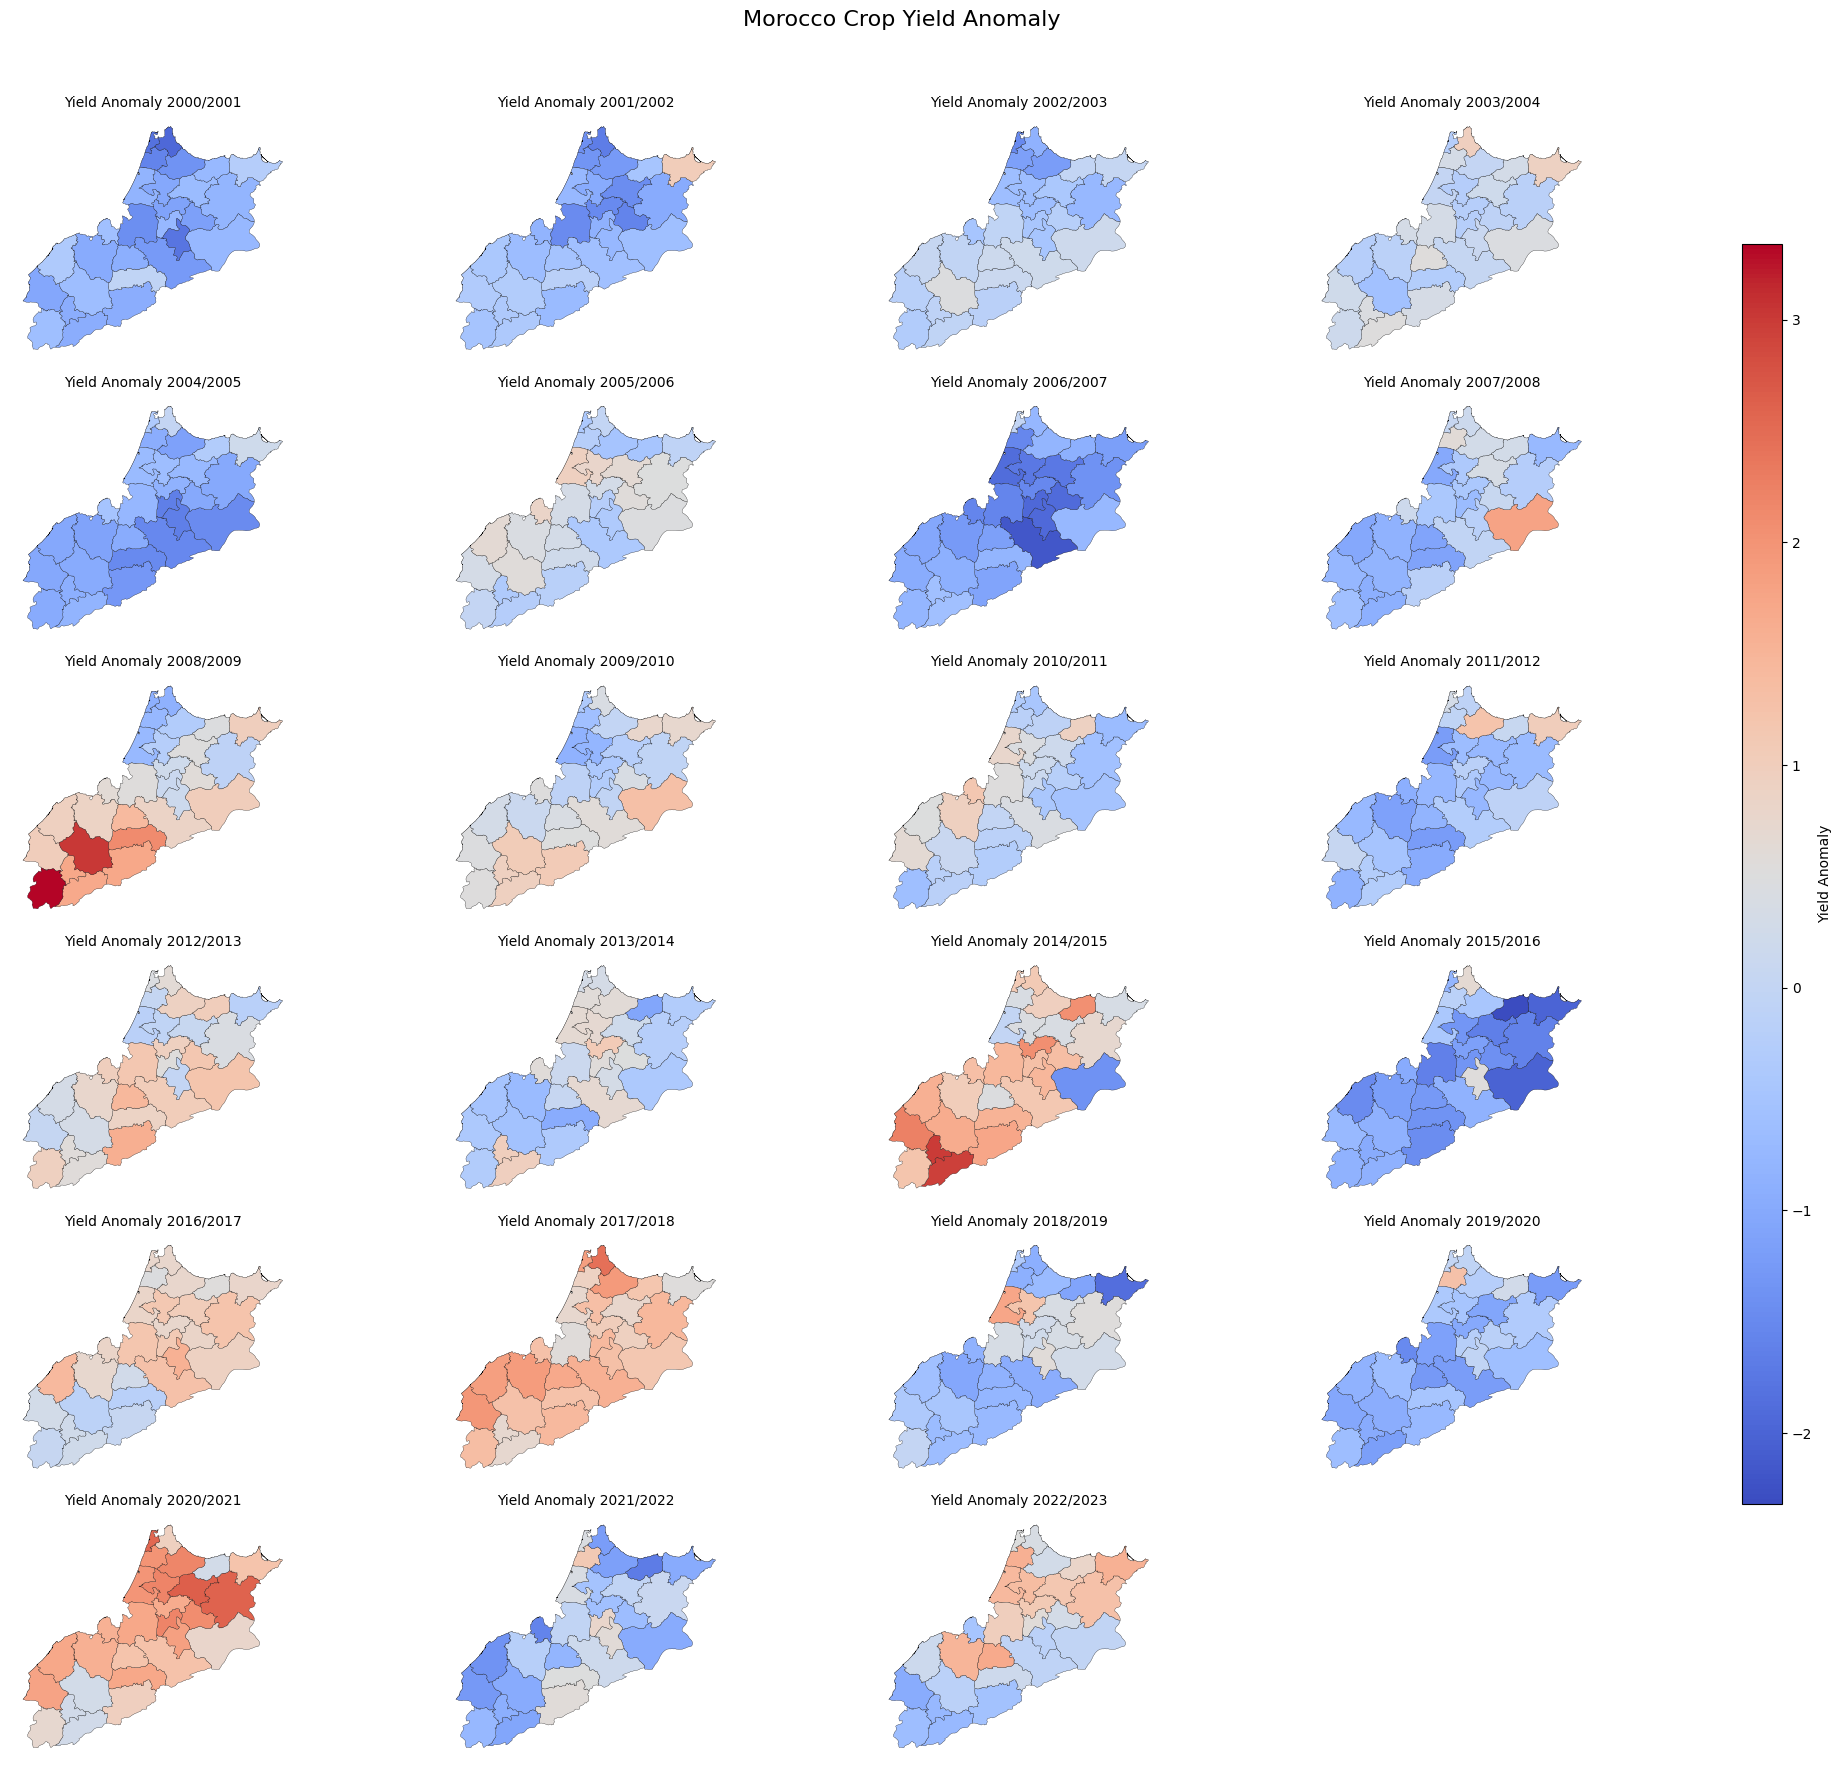

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from fuzzywuzzy import process, fuzz
import unicodedata

# ---------------------------
# 1. 预处理名称统一格式
# ---------------------------
def normalize_name(name):
    """统一名称格式：移除符号、转小写、去除变音符号"""
    if pd.isna(name):
        return ""
    name = ''.join(c for c in str(name) if c.isalnum() or c.isspace())
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode()
    return name.strip().lower()

# ---------------------------
# 2. 加载并预处理数据
# ---------------------------
# 读取 shapefile
shp_path = "/content/drive/MyDrive/shp/final map/MAR.shp"
gdf = gpd.read_file(shp_path)

# 读取 Excel 数据
data_path = "/content/drive/MyDrive/table/Anomaly_Yield_Results.xlsx"
df = pd.read_excel(data_path).set_index('Season_Year')

# ---------------------------
# 3. 自动名称匹配
# ---------------------------
name_mapping = {}
shape_names = gdf.NAME_2.unique()
data_names = df.columns

for data_name in data_names:
    clean_data_name = normalize_name(data_name)
    best_match = process.extractOne(
        clean_data_name,
        [normalize_name(n) for n in shape_names],
        scorer=fuzz.token_sort_ratio
    )
    if best_match[1] > 85:
        original_shape_name = shape_names[[normalize_name(n) == best_match[0] for n in shape_names]][0]
        name_mapping[data_name] = original_shape_name
    else:
        print(f"未匹配到省份：{data_name} (best candidate: {best_match[0]})")

df_renamed = df.rename(columns=name_mapping)

# ---------------------------
# 4. 数据合并
# ---------------------------
merged = gdf.merge(
    df_renamed.T.reset_index(),
    left_on="NAME_2",
    right_on="index",
    how="left"
)

# ---------------------------
# 5. 生成时间序列地图
# ---------------------------
years = [f"{y}/{y+1}" for y in range(2000, 2023)]

# 颜色映射设置
vmin, vmax = df_renamed.min().min(), df_renamed.max().max()
cmap = "coolwarm"
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 定义网格布局
cols = 4
rows = (len(years) + cols - 1) // cols  # 计算所需行数
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)

# 遍历年份并绘制子图
for i, year in enumerate(years):
    ax = axes.flatten()[i]
    if year in df_renamed.index:
        merged.plot(
            column=year, ax=ax, cmap=cmap, norm=norm,
            edgecolor='black', linewidth=0.2, legend=False
        )
        ax.set_title(f"Yield Anomaly {year}", fontsize=10)
        ax.set_axis_off()
    else:
        ax.set_visible(False)  # 隐藏无数据的子图

# 隐藏多余的子图
for ax in axes.flatten()[len(years):]:
    ax.set_visible(False)

# 添加全局颜色条
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # 调整颜色条位置
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cbar_ax, label="Yield Anomaly")

# 添加全局标题
fig.suptitle("Morocco Crop Yield Anomaly", fontsize=16)

plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # 调整布局，留出颜色条空间
plt.show()



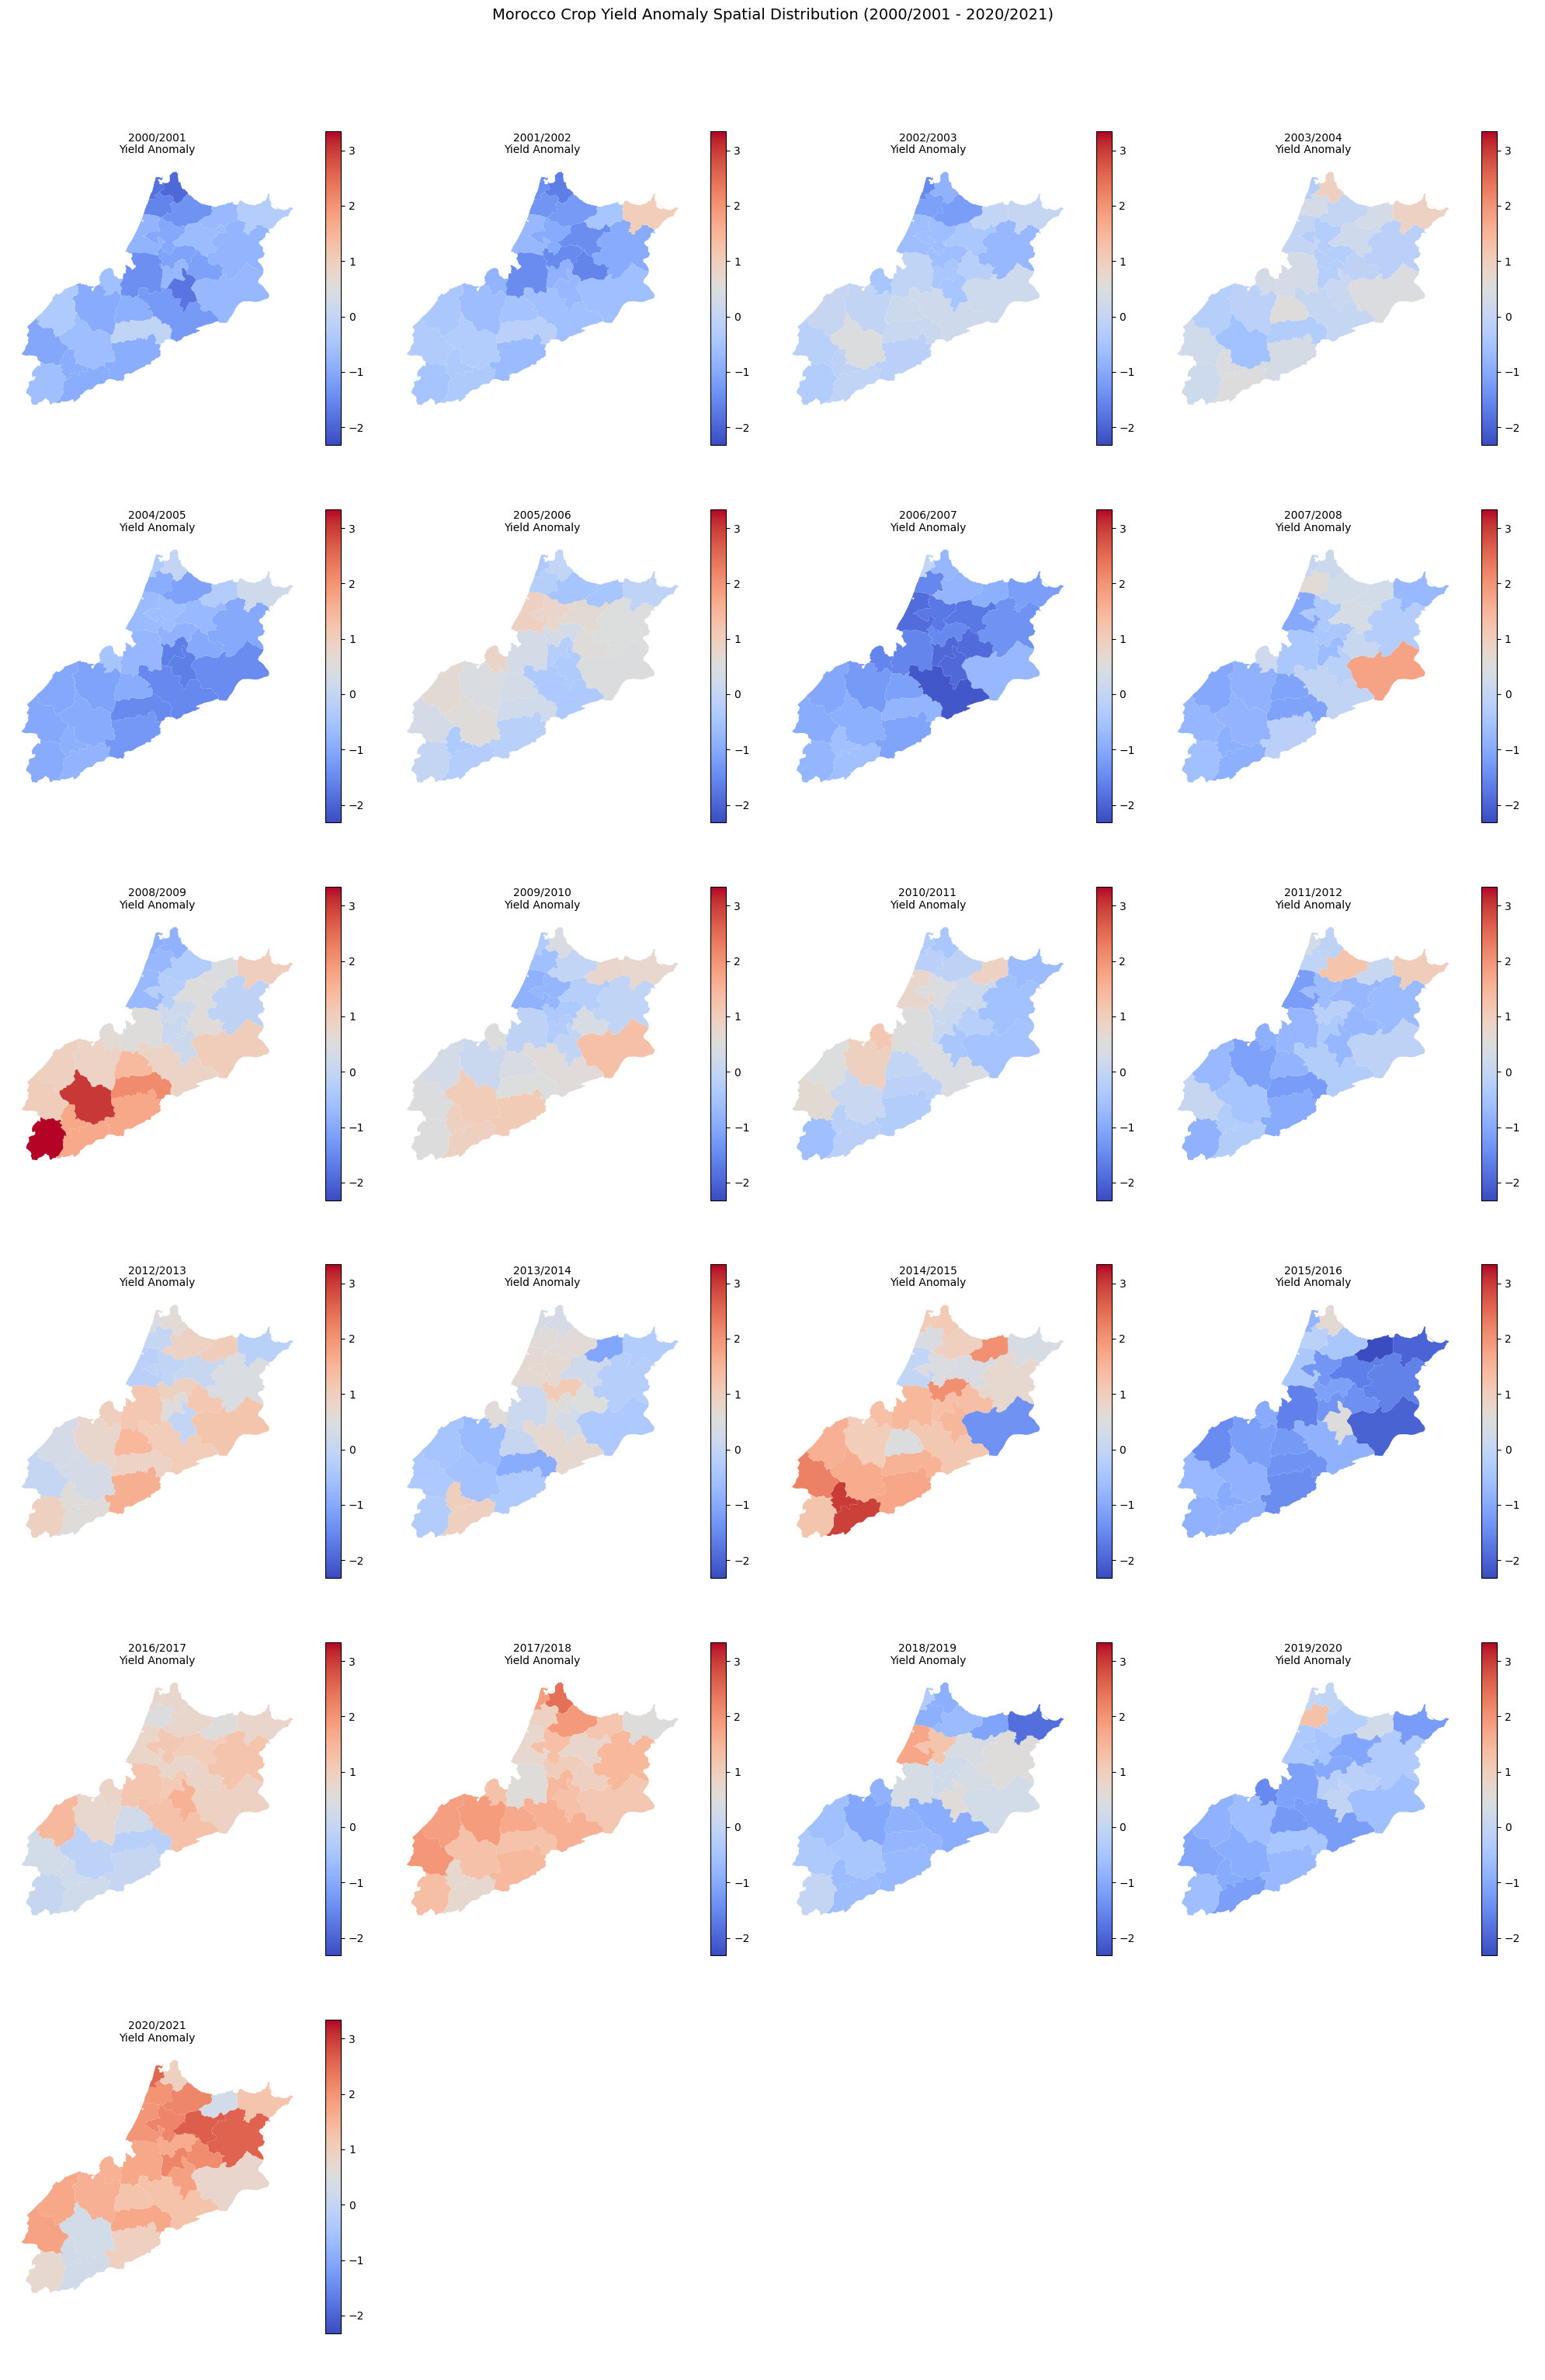

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from fuzzywuzzy import process, fuzz
import unicodedata

# ---------------------------
# 1. 预处理名称统一格式
# ---------------------------
def normalize_name(name):
    """统一名称格式：移除符号、转小写、去除变音符号"""
    if pd.isna(name):
        return ""
    # 移除特殊字符和标点
    name = ''.join(c for c in str(name) if c.isalnum() or c.isspace())
    # 去除变音符号
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode()
    # 统一小写并去除多余空格
    return name.strip().lower()

# ---------------------------
# 2. 加载并预处理数据
# ---------------------------
# 加载shapefile
shp_path = "/content/drive/MyDrive/shp/final map/MAR.shp"
gdf = gpd.read_file(shp_path)

# 加载Yield数据
data_path = "/content/drive/MyDrive/table/Anomaly_Yield_Results.xlsx"
df = pd.read_excel(data_path).set_index('Season_Year')

# ---------------------------
# 3. 自动名称匹配
# ---------------------------
# 创建名称映射字典
name_mapping = {}
shape_names = gdf.NAME_2.unique()
data_names = df.columns

for data_name in data_names:
    # 标准化名称
    clean_data_name = normalize_name(data_name)

    # 模糊匹配最相似的shapefile名称
    best_match = process.extractOne(
        clean_data_name,
        [normalize_name(n) for n in shape_names],
        scorer=fuzz.token_sort_ratio
    )

    # 当匹配度>85%时接受
    if best_match[1] > 85:
        original_shape_name = shape_names[[
            normalize_name(n) == best_match[0] for n in shape_names
        ]][0]
        name_mapping[data_name] = original_shape_name
    else:
        print(f"未匹配到省份：{data_name} (best candidate: {best_match[0]})")

# 重命名数据列以匹配shapefile
df_renamed = df.rename(columns=name_mapping)

# ---------------------------
# 4. 合并数据
# ---------------------------
merged = gdf.merge(
    df_renamed.T.reset_index(),
    left_on="NAME_2",
    right_on="index",
    how="left"
)

# ---------------------------
# 5. 动态生成时间序列图
# ---------------------------
# 设置时间范围
years = [f"{y}/{y+1}" for y in range(2000, 2021)]

# 创建绘图画布
n_cols = 4
n_rows = (len(years) // n_cols) + (1 if len(years) % n_cols else 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

# 统一色标范围
vmin = df_renamed.min().min()
vmax = df_renamed.max().max()

# 绘制每个年份的子图
for idx, year in enumerate(years):
    ax = axes[idx]
    # 检查年份是否存在
    if year in df_renamed.index:
        merged.plot(
            column=year,
            cmap="coolwarm",
            ax=ax,
            legend=True,
            legend_kwds={'shrink':0.8},
            vmin=vmin,
            vmax=vmax,
            missing_kwds={
                "color": "lightgrey",
                "edgecolor": "black",
                "hatch": "//",
                "label": "Missing Data"
            }
        )
        ax.set_title(f"{year}\nYield Anomaly", fontsize=10)
        ax.set_axis_off()
    else:
        ax.axis('off')

# 隐藏多余子图
for j in range(len(years), len(axes)):
    axes[j].axis('off')

# 添加主标题
plt.suptitle("Morocco Crop Yield Anomaly Spatial Distribution (2000/2001 - 2020/2021)",
             y=1.02, fontsize=14)
plt.tight_layout()

# 保存高清图片
plt.savefig(
    "/content/drive/MyDrive/Yield_Anomaly_Maps.png",
    dpi=300,
    bbox_inches='tight'
)
plt.show()

# 输出匹配结果


<ipython-input-21-81a32f02d99d>:52: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-21-81a32f02d99d>:52: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-21-81a32f02d99d>:52: UserWarning: Glyph 30465 (\N{CJK UNIFIED IDEOGRAPH-7701}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-21-81a32f02d99d>:52: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-21-81a32f02d99d>:52: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-21-81a32f02d99d>:52: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,

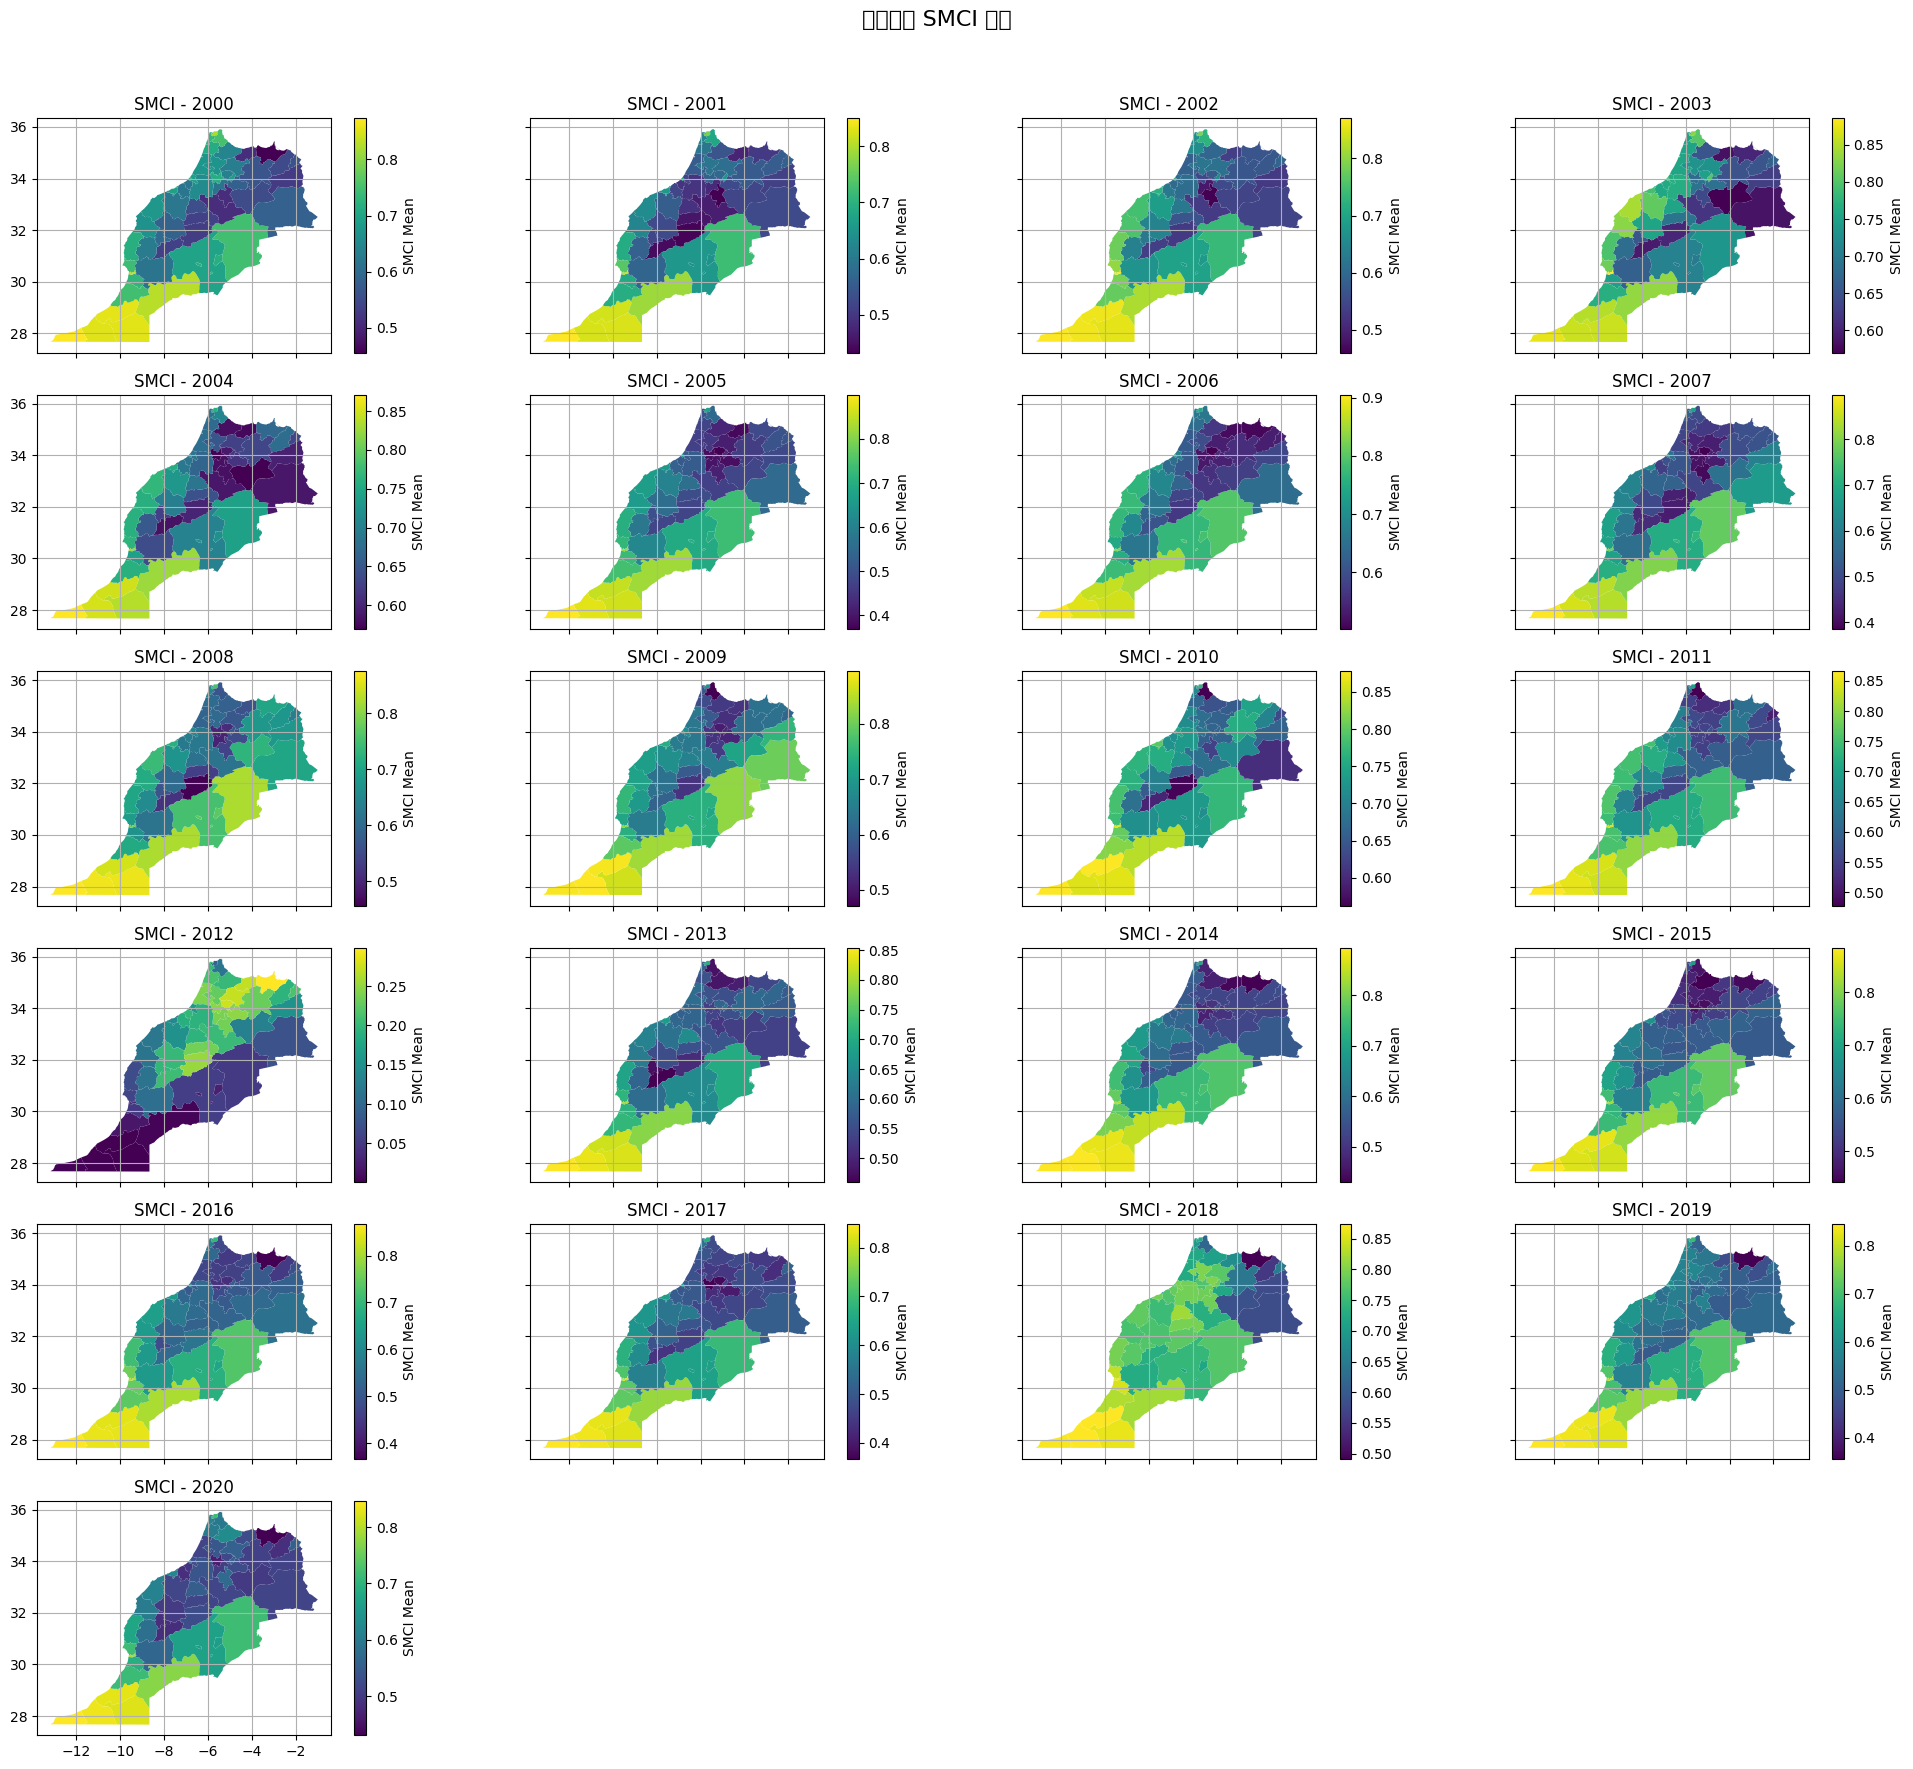

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取 Shapefile
shapefile_path = "/content/drive/MyDrive/shp/gadm41_MAR_2.shp"
gdf = gpd.read_file(shapefile_path)

# 读取 CSV 数据
csv_path = "/content/drive/MyDrive/SoilMoisture_Morocco_SMCI_Provinces1.csv"
df = pd.read_csv(csv_path)

# 解析 YYYYMM 格式的日期
df['Date'] = pd.to_datetime(df['Month'].astype(str), format='%Y%m')

# 提取年份并计算年度平均值
df['Year'] = df['Date'].dt.year
annual_avg_df = df.groupby(['Province', 'Year'])['SMCI_Mean'].mean().reset_index()

# 将年度平均数据与 Shapefile 数据根据省份合并
gdf = gdf.merge(annual_avg_df, left_on='NAME_2', right_on='Province', how='left')

# 获取所有年份
years = df['Year'].unique()

# 根据每行4个图来设置子图网格
cols = 4
rows = (len(years) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)

# 绘制每年的数据
for i, year in enumerate(years):
    ax = axes.flatten()[i]  # 获取对应的子图
    # 获取该年份的SMCI数据
    year_data = gdf[gdf['Year'] == year]

    # 在每个省的边界内绘制 SMCI 值
    year_data.plot(column='SMCI_Mean', ax=ax, legend=True, cmap='viridis',
                   legend_kwds={'label': "SMCI Mean"})

    # 设置标题
    ax.set_title(f"SMCI - {year}")

    ax.grid(True)

# 隐藏多余的子图
for ax in axes.flatten()[len(years):]:
    ax.set_visible(False)

fig.suptitle("各年省份 SMCI 分布", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<ipython-input-25-f1ad9871277f>:52: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-25-f1ad9871277f>:52: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-25-f1ad9871277f>:52: UserWarning: Glyph 30465 (\N{CJK UNIFIED IDEOGRAPH-7701}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-25-f1ad9871277f>:52: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-25-f1ad9871277f>:52: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-25-f1ad9871277f>:52: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,

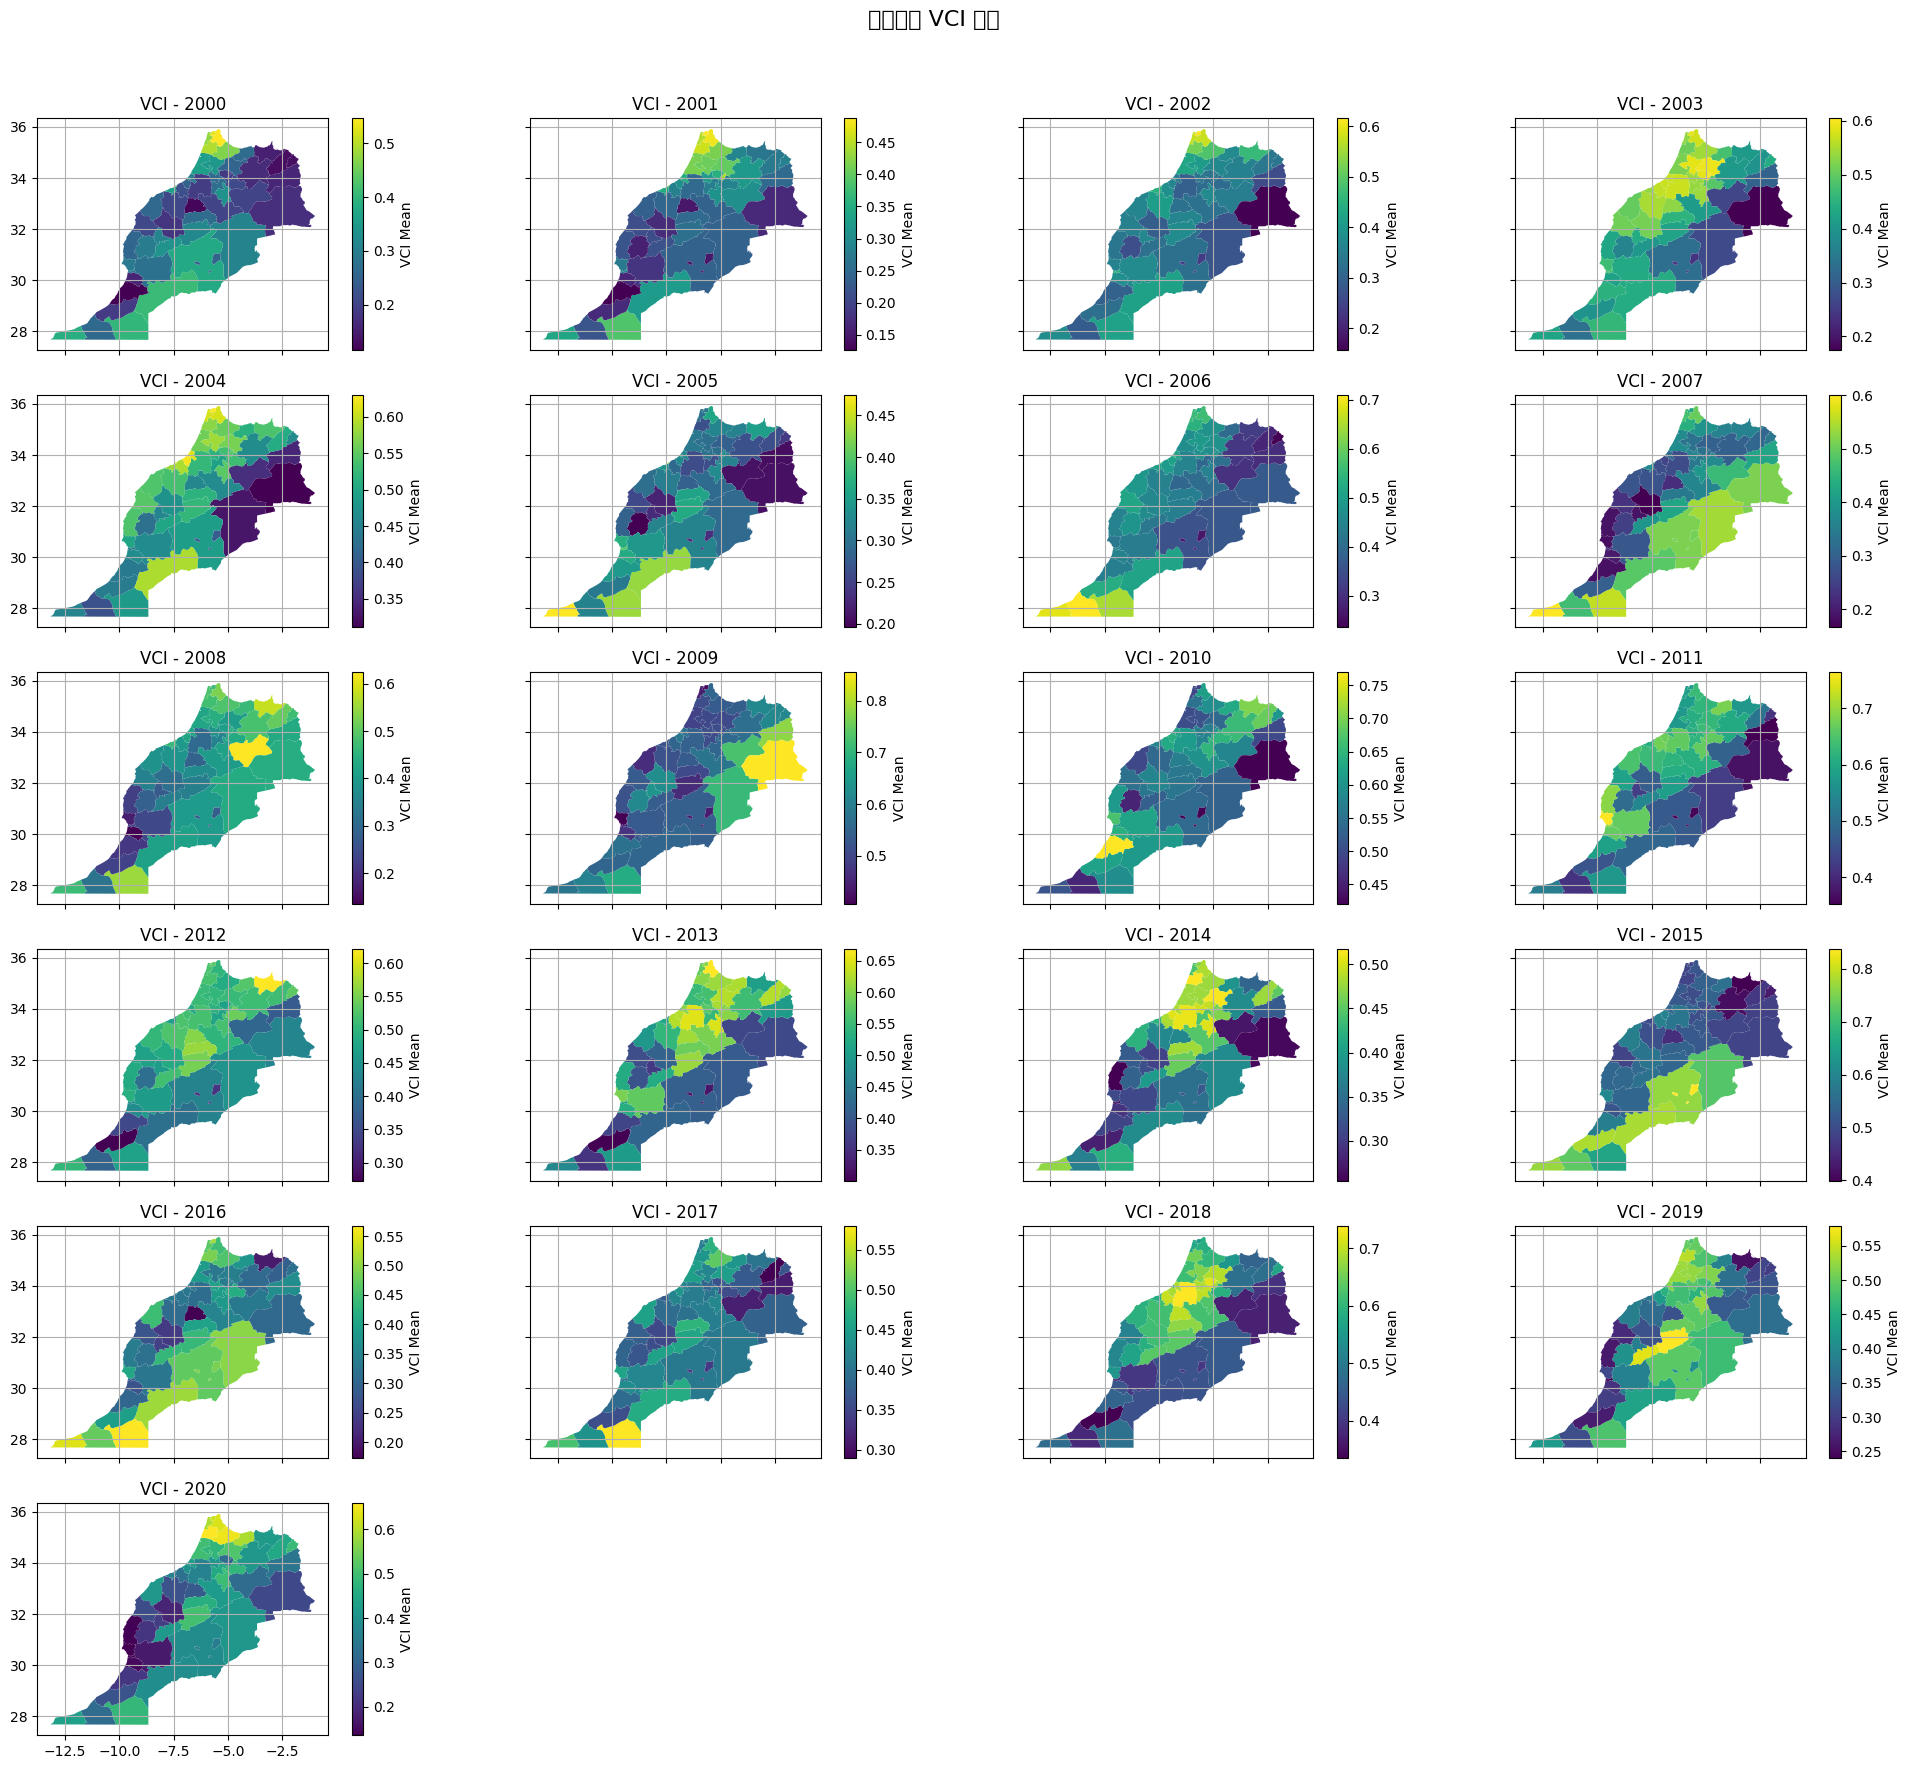

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取 Shapefile
shapefile_path = "/content/drive/MyDrive/shp/gadm41_MAR_2.shp"
gdf = gpd.read_file(shapefile_path)

# 读取 VCI 数据
vci_csv_path = "/content/drive/MyDrive/VCI_monthly_by_province.csv"
vci_df = pd.read_csv(vci_csv_path)

# 计算年度 VCI 平均值（确保按省份和年份正确分组）
annual_avg_vci_df = vci_df.groupby(['Province', 'Year'])['VCI_mean'].mean().reset_index()

# 将年度平均数据与 Shapefile 数据根据省份合并
gdf = gdf.merge(annual_avg_vci_df, left_on='NAME_2', right_on='Province', how='left')

# 获取所有年份
years = vci_df['Year'].unique()

# 根据每行4个图来设置子图网格
cols = 4
rows = (len(years) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)

# 绘制每年的 VCI 数据
for i, year in enumerate(years):
    ax = axes.flatten()[i]  # 获取对应的子图
    # 获取该年份的 VCI 数据
    year_data = gdf[gdf['Year'] == year]

    # 确保没有缺失值
    if year_data['VCI_mean'].isnull().sum() > 0:
        print(f"Warning: Missing data for year {year}.")

    # 在每个省的边界内绘制 VCI 值
    year_data.plot(column='VCI_mean', ax=ax, legend=True, cmap='viridis',
                   legend_kwds={'label': "VCI Mean"})

    # 设置标题
    ax.set_title(f"VCI - {year}")

    ax.grid(True)

# 隐藏多余的子图
for ax in axes.flatten()[len(years):]:
    ax.set_visible(False)

fig.suptitle("各年省份 VCI 分布", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
